In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from scipy.stats import spearmanr
import subprocess
import pickle
import os

In [2]:
# list all tsv files in target_idr
target_dir = 'data/original/tsv/'
all_files = os.listdir(target_dir)

pbmcfreq_train = pd.read_csv(target_dir + 'training_pbmc_cell_frequency_long.tsv', sep='\t')
pbmcfreq_chal = pd.read_csv(target_dir + 'challenge_pbmc_cell_frequency_long.tsv', sep='\t')
pbmcfreq = pd.concat([pbmcfreq_train, pbmcfreq_chal])
pbmcfreq = pbmcfreq.rename(columns={'cell_type_name': 'variable', 'percent_live_cell': 'value'})
pbmcfreq = pbmcfreq[['specimen_id', 'variable', 'value']]

genexp_train = pd.read_csv(target_dir + 'training_pbmc_gene_expression_long.tsv', sep='\t')
genexp_chal = pd.read_csv(target_dir + 'challenge_pbmc_gene_expression_long.tsv', sep='\t')
genexp = pd.concat([genexp_train, genexp_chal])
genexp = genexp.rename(columns={'versioned_ensembl_gene_id': 'variable', 'tpm': 'value'})
genexp = genexp[['specimen_id', 'variable', 'value']]

cytoplex_train = pd.read_csv(target_dir + 'training_plasma_cytokine_concentrations_by_legendplex_long.tsv', sep='\t')
cytoplex_chal = pd.read_csv(target_dir + 'challenge_plasma_cytokine_concentrations_by_legendplex_long.tsv', sep='\t')
cytoplex = pd.concat([cytoplex_train, cytoplex_chal])
cytoplex = cytoplex.rename(columns={'protein_id': 'variable', 'concentration': 'value'})
cytoplex = cytoplex[['specimen_id', 'variable', 'value']]
cytoplex['variable'] = cytoplex['variable'] + '_plex'

cytolink_train = pd.read_csv(target_dir + 'training_plasma_cytokine_concentrations_by_olink_long.tsv', sep='\t')
cytolink_chal = pd.read_csv(target_dir + 'challenge_plasma_cytokine_concentrations_by_olink_long.tsv', sep='\t')
cytolink = pd.concat([cytolink_train, cytolink_chal])
cytolink = cytolink.rename(columns={'protein_id': 'variable', 'concentration': 'value'})
cytolink = cytolink[['specimen_id', 'variable', 'value']]
cytolink['variable'] = cytolink['variable'] + '_link'

tact_train = pd.read_csv(target_dir + 'training_t_cell_activation_long.tsv', sep='\t')
tact_chal = pd.read_csv(target_dir + 'challenge_t_cell_activation_long.tsv', sep='\t')
tact = pd.concat([tact_train, tact_chal])
tact = tact.rename(columns={'stimulation': 'variable', 'analyte_percentages': 'value'})
tact = tact[['specimen_id', 'variable', 'value']]

tpol_train = pd.read_csv(target_dir + 'training_t_cell_polarization_long.tsv', sep='\t')
tpol_chal = pd.read_csv(target_dir + 'challenge_t_cell_polarization_long.tsv', sep='\t')
tpol = pd.concat([tpol_train, tpol_chal])
tpol = tpol.rename(columns={'stimulation_protein_id': 'variable', 'analyte_counts': 'value'})
tpol = tpol[['specimen_id', 'variable', 'value']]   

ab_train = pd.read_csv(target_dir + 'training_plasma_antibody_levels_long.tsv', sep='\t')
ab_chal = pd.read_csv(target_dir + 'challenge_plasma_antibody_levels_long.tsv', sep='\t')
ab = pd.concat([ab_train, ab_chal])
ab = ab.rename(columns={'isotype_antigen': 'variable', 'MFI_normalised': 'value'})
ab = ab[['specimen_id', 'variable', 'value']]

combined_long = pd.concat([pbmcfreq, genexp, cytoplex, cytolink, tact, tpol, ab])

In [3]:
sub_info_training = pd.read_csv('data/original/tsv/training_subject_specimen.tsv', sep='\t')
sub_info_challenge = pd.read_csv('data/original/tsv/challenge_subject_specimen.tsv', sep='\t')
sub_info = pd.concat([sub_info_training, sub_info_challenge])

sub_selected = sub_info[['subject_id', 'infancy_vac', 'biological_sex', 'ethnicity', 'year_of_birth', 'date_of_boost', 'dataset']].drop_duplicates()
sub_selected['years_from_boost'] = 2024 - sub_selected['date_of_boost'].str.split('-').str[0].astype(float)
sub_selected['age'] = 2024 - sub_selected['year_of_birth'].str.split('-').str[0].astype(float)
sub_selected = sub_selected.drop(columns=['year_of_birth', 'date_of_boost'])

In [4]:
spec_to_timepoint = sub_info[['specimen_id', 'subject_id', 'timepoint']].drop_duplicates()
combined_to_timepoint = pd.merge(combined_long, spec_to_timepoint, on='specimen_id', how='inner')
combined_to_timepoint['variable'] = combined_to_timepoint['variable'] + '__' + combined_to_timepoint['timepoint'].astype(str)
combined_to_timepoint = combined_to_timepoint.drop(columns=['specimen_id', 'timepoint'])

In [5]:
data = combined_to_timepoint.pivot(index='subject_id', columns='variable', values='value').reset_index()
data = pd.merge(data, sub_selected, on='subject_id', how='left')
data = data.set_index('subject_id')
is_training = data['dataset'] != '2023_dataset'
data = data.drop(columns=['dataset'])

In [6]:
# ages to numerical
numerical_columns = data.select_dtypes(include=[np.number]).columns
categorical_columns = data.columns.difference(numerical_columns)
numeric_x = data[numerical_columns]
categorical_columns = data[categorical_columns]
categorical_columns = pd.get_dummies(categorical_columns)
data = pd.concat([numeric_x, categorical_columns], axis=1)

In [7]:
training = data[is_training].copy()
challenge = data[~is_training].copy()

col_tuples = [
    ('ENSG00000277632.1__3', 'ENSG00000277632.1__0'),
    ('Monocytes__1', 'Monocytes__0'),
    ('IgG_PT__14', 'IgG_PT__0'),
]
for int_tuple in col_tuples:
    training['pred_' + int_tuple[0]] = training[int_tuple[0]] 
    training['pred_fc_' + int_tuple[0]] = np.log2(training[int_tuple[0]] / training[int_tuple[1]])

In [8]:
training['pred_bonus'] = np.log2(training['PHA_P01579__30'] / training['PHA_P05113__30'])

In [9]:
# compute all variances across columns
vars = challenge.var(axis=0)
cols_to_keep = vars[vars > 0].index

In [10]:
x = training[cols_to_keep].copy()
x_challenge = challenge[cols_to_keep].copy()
y = training.filter(regex='^pred_').copy()

/Users/mrodrigu/miniforge3/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/mrodrigu/miniforge3/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mrodrigu/miniforge3/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mrodrigu/miniforge3/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When groupin

<Axes: xlabel='feature', ylabel='spearman'>

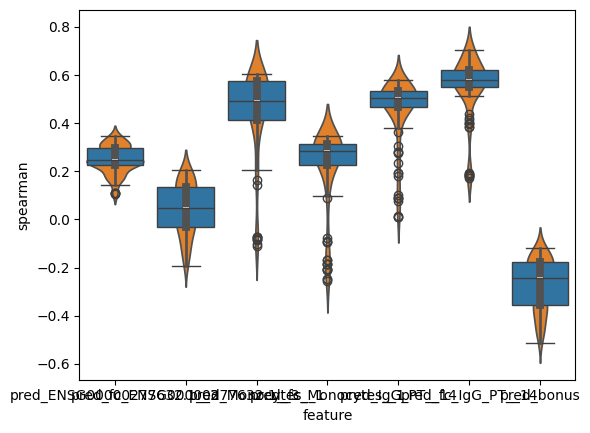

In [ ]:
final_results = pd.read_csv('data/hyperparam_harmdata.csv')
sns.boxplot(data=final_results, x='feature', y='spearman')
sns.violinplot(data=final_results, x='feature', y='spearman')

In [15]:
# for each feature, get the best parameters
best_params = final_results.loc[final_results.groupby('feature')['spearman'].idxmax()]
best_params

,feature,spearman,n_folds,n_estimators,max_depth,learning_rate,summary
735,pred_ENSG00000277632.1__3,0.346413,5,100,7,0.005,mean
599,pred_IgG_PT__14,0.577685,5,500,3,0.050,mean
646,pred_Monocytes__1,0.602965,5,100,9,0.050,mean
300,pred_bonus,-0.117056,5,50,5,0.100,mean
386,pred_fc_ENSG00000277632.1__3,0.205037,5,100,3,0.050,mean
390,pred_fc_IgG_PT__14,0.703589,5,100,3,0.050,mean
346,pred_fc_Monocytes__1,0.347353,5,100,3,0.100,mean


In [17]:
final_preds = {}
# iterate over rows
for i, row in best_params.iterrows():
    int_feature = row['feature']
    n_folds = row['n_folds']
    n_estimators = row['n_estimators']
    max_depth = row['max_depth']
    learning_rate = row['learning_rate']
    summary = row['summary']

    print(int_feature)

    # define x and y
    int_y = y[[int_feature]]
    nan_index = int_y[int_y.isna().any(axis=1)].index
    int_y = int_y.drop(nan_index)
    int_x = x.drop(nan_index)

    # prepare kfold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    challenge_predictions = []
    for k, (train_index, test_index) in enumerate(kf.split(int_x)):

        print('Fold: ' + str(k))

        x_train, x_test = int_x.iloc[train_index], int_x.iloc[test_index]
        y_train, y_test = int_y.iloc[train_index], int_y.iloc[test_index]

        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, early_stopping_rounds=50)
        model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
        
        challenge_pred = model.predict(x_challenge, iteration_range=(0, model.best_iteration))
        challenge_predictions.append(challenge_pred)
    
    if summary == 'mean':
        challenge_pred = np.mean(challenge_predictions, axis=0)
    elif summary == 'median':
        challenge_pred = np.median(challenge_predictions, axis=0)

    final_preds[int_feature] = challenge_pred

pred_ENSG00000277632.1__3
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_IgG_PT__14
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_Monocytes__1
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_bonus
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_fc_ENSG00000277632.1__3
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_fc_IgG_PT__14
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
pred_fc_Monocytes__1
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [18]:
# create dataframe with final preds
final_pred_df = pd.DataFrame(final_preds)
# in the columns that contain a fc, check if the

col_tuples = [
    ('ENSG00000277632.1__3', 'ENSG00000277632.1__0'),
    ('Monocytes__1', 'Monocytes__0'),
    ('IgG_PT__14', 'IgG_PT__0'),
]

# for columns that contain fc, if the second tuple element in challenge data is NaN, set NaN in the final_pred_df
for i, (j,row) in enumerate(x_challenge.iterrows()):
    for int_tuple in col_tuples:
        if np.isnan(row[int_tuple[1]]):
            final_pred_df.loc[i, 'pred_fc_' + int_tuple[0]] = np.nan

In [19]:
final_pred_df['subject_id'] = challenge.index

In [21]:
# read challenge template
template = pd.read_csv('data/original/myIgGModel_submission_v20240927.tsv', sep='\t')
template_filled = template.copy()

In [22]:
# rearrange final pred df so that the order of subject_id matches the template SubjectID column
sorted = final_pred_df.copy()
sorted = sorted.set_index('subject_id').loc[template['SubjectID']].reset_index()
assert all(sorted['subject_id'] == template['SubjectID'])

In [23]:
template_filled['1.1) IgG-PT-D14-titer-Rank'] = sorted['pred_IgG_PT__14']
template_filled['1.1) IgG-PT-D14-titer-Rank'] = template_filled['1.1) IgG-PT-D14-titer-Rank'].rank(ascending=False)
template_filled['1.2) IgG-PT-D14-FC-Rank'] = sorted['pred_fc_IgG_PT__14']
template_filled['1.2) IgG-PT-D14-FC-Rank'] = template_filled['1.2) IgG-PT-D14-FC-Rank'].rank(ascending=False)
template_filled['2.1) Monocytes-D1-Rank'] = sorted['pred_Monocytes__1']
template_filled['2.1) Monocytes-D1-Rank'] = template_filled['2.1) Monocytes-D1-Rank'].rank(ascending=False)
template_filled['2.2) Monocytes-D1-FC-Rank'] = sorted['pred_fc_Monocytes__1']
template_filled['2.2) Monocytes-D1-FC-Rank'] = template_filled['2.2) Monocytes-D1-FC-Rank'].rank(ascending=False)
template_filled['3.1) CCL3-D3-Rank'] = sorted['pred_ENSG00000277632.1__3']
template_filled['3.1) CCL3-D3-Rank'] = template_filled['3.1) CCL3-D3-Rank'].rank(ascending=False)
template_filled['3.2) CCL3-D3-FC-Rank'] = sorted['pred_fc_ENSG00000277632.1__3']
template_filled['3.2) CCL3-D3-FC-Rank'] = template_filled['3.2) CCL3-D3-FC-Rank'].rank(ascending=False)
template_filled['4.1) IFNG/IL5-Polarization-D30-Rank'] = sorted['pred_bonus']
template_filled['4.1) IFNG/IL5-Polarization-D30-Rank'] = template_filled['4.1) IFNG/IL5-Polarization-D30-Rank'].rank(ascending=False)
template_filled.to_csv('data/final_submission_2.tsv', sep='\t', index=False)